In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

In [35]:
DATA_PATH = 'Student Depression Dataset.csv'
df = pd.read_csv(DATA_PATH)

In [36]:
print("shape:", df.shape)
print(df.head())
print(df.info())
print("missing values: \n", df.isna().sum())

shape: (27901, 18)
   id  Gender   Age           City Profession  Academic Pressure  \
0   2    Male  33.0  Visakhapatnam    Student                5.0   
1   8  Female  24.0      Bangalore    Student                2.0   
2  26    Male  31.0       Srinagar    Student                3.0   
3  30  Female  28.0       Varanasi    Student                3.0   
4  32  Female  25.0         Jaipur    Student                4.0   

   Work Pressure  CGPA  Study Satisfaction  Job Satisfaction  \
0            0.0  8.97                 2.0               0.0   
1            0.0  5.90                 5.0               0.0   
2            0.0  7.03                 5.0               0.0   
3            0.0  5.59                 2.0               0.0   
4            0.0  8.13                 3.0               0.0   

      Sleep Duration Dietary Habits   Degree  \
0          5-6 hours        Healthy  B.Pharm   
1          5-6 hours       Moderate      BSc   
2  Less than 5 hours        Healthy       B

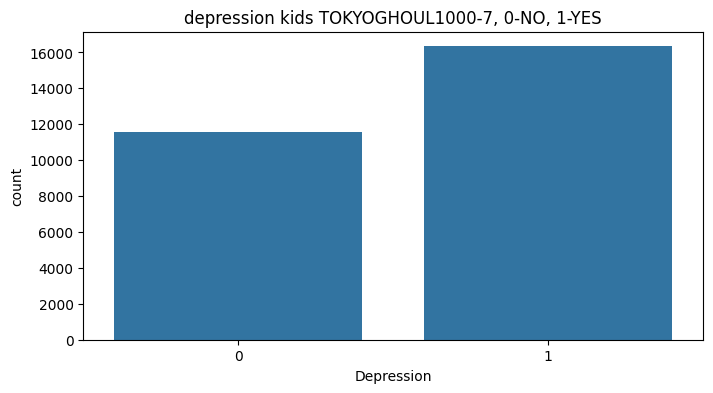

In [37]:
plt.figure(figsize=(8,4))
sns.countplot(x='Depression', data=df)
plt.title("depression kids TOKYOGHOUL1000-7, 0-NO, 1-YES")
plt.show()

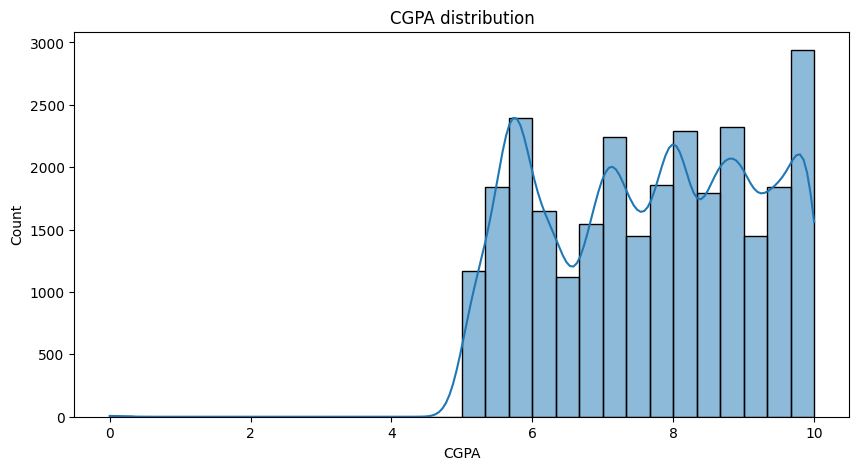

In [38]:
plt.figure(figsize=(10,5))
sns.histplot(df['CGPA'], bins=30, kde=True)
plt.title('CGPA distribution')
plt.show()

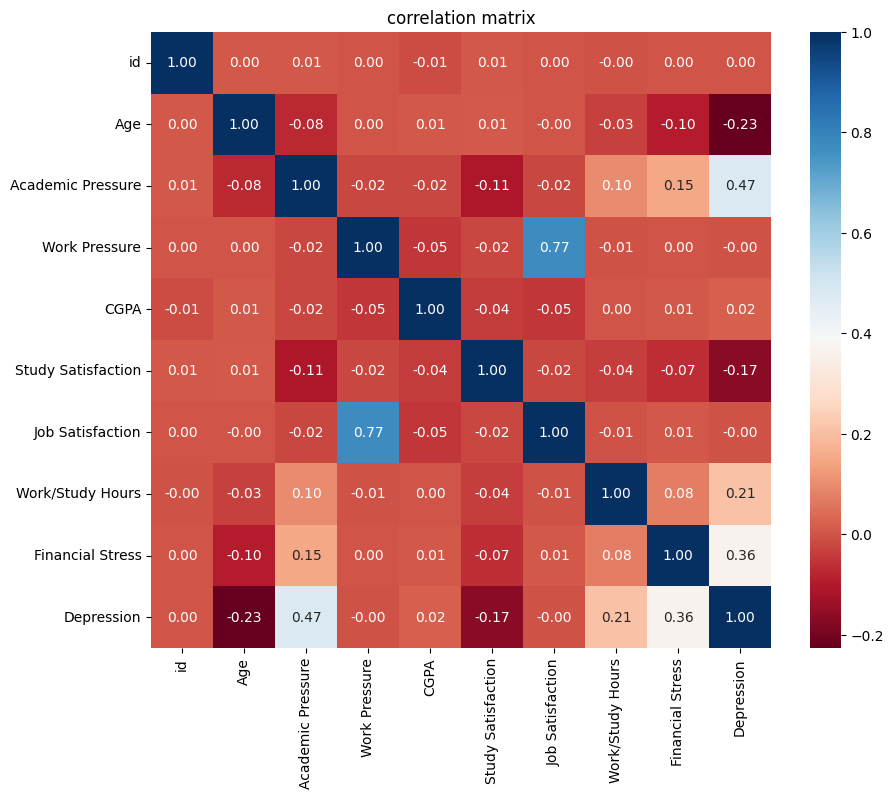

In [39]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap='RdBu')
plt.title('correlation matrix')
plt.show()

In [40]:
for col in df.columns:
    if df[col].isna().sum() > 0:
        if df[col].dtype=='object':
            df[col] = df[col].fillna(df[col].mode()[0])
        else:
            df[col] = df[col].fillna(df[col].median())

In [41]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols = [c for c in cat_cols if c != 'Depression']
df_enc = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [42]:
features = [c for c in df_enc.columns if c != 'Depression']
X = df_enc[features].values
y = df_enc['Depression'].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [44]:
class LogisticRegression:
    def __init__(self, lr=0.1, n_iters=1000, fit_intercept=True, verbose=False):
        self.lr = lr
        self.n_iters = n_iters
        self.fit_intercept = fit_intercept
        self.verbose = verbose
        self.w = None
        self.b = None

    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0.0

        for i in range(self.n_iters):
            linear_model = X.dot(self.w) + self.b
            y_pred = self.__sigmoid(linear_model)

            dw = (1 / n_samples) * X.T.dot(y_pred - y)
            db = (1 / n_samples) * np.sum(y_pred - y)

            self.w -= self.lr * dw
            self.b -= self.lr * db

            if self.verbose and i % (self.n_iters // 10 + 1) == 0:
                loss = -np.mean(y*np.log(y_pred+1e-15) + (1-y)*np.log(1-y_pred+1e-15))
                print(f"iter {i}, loss={loss:.4f}")

    def predict_proba(self, X):
        linear_model = X.dot(self.w) + self.b
        return self.__sigmoid(linear_model)

    def predict(self, X, threshold=0.5):
        probs = self.predict_proba(X)
        return (probs >= threshold).astype(int)

In [45]:
model = LogisticRegression(lr=0.5, n_iters=4000, verbose=True)
model.fit(X_train, y_train)

iter 0, loss=0.6931
iter 401, loss=0.3449
iter 802, loss=0.3449
iter 1203, loss=0.3449
iter 1604, loss=0.3449
iter 2005, loss=0.3449
iter 2406, loss=0.3449
iter 2807, loss=0.3449
iter 3208, loss=0.3449
iter 3609, loss=0.3449


In [46]:
y_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("accuracy:", acc)
print("precision:", prec)
print("recall:", rec)
print("F1:", f1)

accuracy: 0.844293137430568
precision: 0.8585949177877429
recall: 0.8788249694002448
F1: 0.8685921669438984


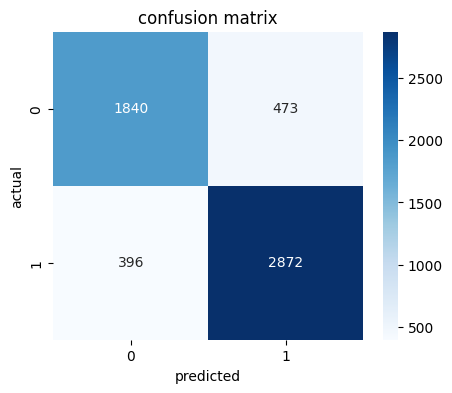

In [47]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('confusion matrix')
plt.show()

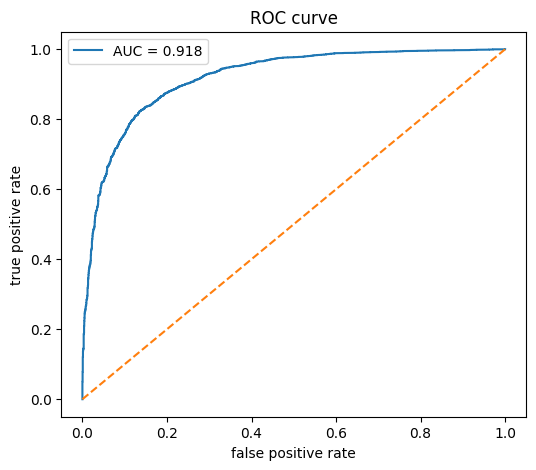

In [48]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC curve')
plt.legend()
plt.show()

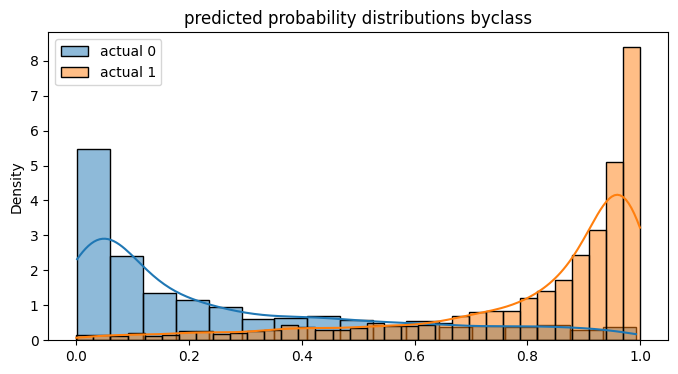

In [49]:
plt.figure(figsize=(8,4))
sns.histplot(y_proba[y_test==0], label='actual 0', kde=True, stat='density')
sns.histplot(y_proba[y_test==1], label='actual 1', kde=True, stat='density')
plt.legend()
plt.title('predicted probability distributions byclass')
plt.show()